In [1]:
%cd ../code/

/opt/ml/team/gj/code


In [2]:
import pandas as pd
import csv
import numpy as np
from PIL import Image, ImageOps
import math
from attrdict import AttrDict

from dataset import (
    dataset_loader, SizeBatchSampler, split_gt, load_levels, load_sources, load_vocab, encode_truth
)

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torchvision import transforms

import matplotlib.pyplot as plt
from IPython.display import display, HTML

In [3]:
!ls /opt/ml/input/data

dummy  dummy_2	eval_dataset  out_stuff  rot_model  saving_model  train_dataset


In [4]:
root = '/opt/ml/input/data/train_dataset'
image_root = f'{root}/images'
source_f = open(f'{root}/source.txt')
sources = [line.strip().split('\t') for line in source_f.readlines()]
sources = [(x, int(y)) for x, y in sources]

In [5]:
level_f = open(f'{root}/level.txt')
levels = [line.strip().split('\t') for line in level_f.readlines()]
levels = [(x, int(y)) for x, y in levels]

In [6]:
gt_f = open(f'{root}/gt.txt')
gts = [line.strip().split('\t') for line in gt_f.readlines()]

In [7]:
sources_df = pd.DataFrame(sources, columns=['path', 'source'])
gts_df = pd.DataFrame(gts, columns=['path', 'gt'])
levels_df = pd.DataFrame(levels, columns=['path', 'level'])

len(sources_df), len(gts_df), len(levels_df)

(100000, 100000, 100000)

In [8]:
merged = sources_df.merge(levels_df).merge(gts_df)

In [9]:
class CustomDataset(Dataset):
    """Load Dataset"""

    def __init__(
        self,
        groundtruth,
        tokens_file,
        levels,
        sources,
        crop=False,
        transform=None,
        rgb=3,
        max_resolution=128*128,
        is_flexible=False,
    ):
        """
        Args:
            groundtruth (string): Path to ground truth TXT/TSV file
            tokens_file (string): Path to tokens TXT file
            ext (string): Extension of the input files
            crop (bool, optional): Crop images to their bounding boxes [Default: False]
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        super(CustomDataset, self).__init__()
        self.crop = crop
        self.transform = transform
        self.rgb = rgb
        self.token_to_id, self.id_to_token = load_vocab(tokens_file)
        self.data = [
            {
                "path": p,
                "truth": {
                    "text": truth,
                    "encoded": [
                        self.token_to_id[START],
                        *encode_truth(truth, self.token_to_id),
                        self.token_to_id[END],
                    ],
                },
            }
            for idx, (p, truth) in enumerate(groundtruth)
        ]
        
        self.data_len = len(self.data)

        for datum in self.data:
            file_path = datum['path'].split('/')[-1]
            source = sources.get(file_path, -100) # -100 crossentory 무시 index
            level = levels.get(file_path, -99) - 1 # -100 모름
            datum['source'] = source
            datum['level'] = level

        self.is_flexible = is_flexible
        if self.is_flexible:
            self.shape_cache = np.zeros((len(self), 2), dtype=int)
            self.max_resolution = max_resolution


    def __len__(self):
        return self.data_len * 8

    def __getitem__(self, i):
        idx = i // 8
        img_idx = i % 8
        rot_idx = img_idx % 4
        flip_idx = img_idx // 4
        
        item = self.data[idx]
        image = Image.open(item["path"])
        if self.rgb == 3:
            image = image.convert("RGB")
        elif self.rgb == 1:
            image = image.convert("L")
        else:
            raise NotImplementedError

        if self.crop:
            # Image needs to be inverted because the bounding box cuts off black pixels,
            # not white ones.
            bounding_box = ImageOps.invert(image).getbbox()
            image = image.crop(bounding_box)

        if self.transform:
            image = self.transform(image)

        if self.is_flexible:
            image = transforms.Resize(self.get_shape_before(i))(image)
            
        angle = int(rot_idx * 90)

        image = transforms.functional.rotate(image, angle, expand=True)

        
        if flip_idx == 1:
            image = transforms.functional.hflip(image)
  

        return {
            "path": item["path"],
            "truth": item["truth"],
            "image": image,
            'source': item['source'],
            'level': item['level'],
            'rot': rot_idx,
            'flip': flip_idx,
        }
    
    def get_shape_before(self, i):
        h, w = self.get_shape(i)
        img_idx = i % 8
        rot_idx = img_idx % 4
        if rot_idx % 2 == 1:
            h, w = w, h
        
        return h, w

    def get_shape(self, i):
        h, w = self.shape_cache[i]
        if h == 0 and w == 0:
            idx = i // 8
            img_idx = i % 8
            rot_idx = img_idx % 4
            flip_idx = img_idx // 4
            
            item = self.data[idx]
            image = Image.open(item["path"])
            rw, rh = image.size

            T = self.max_resolution
            div = rw * rh / T
            w = round(rw/math.sqrt(div))
            h = round(rh/math.sqrt(div))
            w = round(w / 32) * 32
            h = T // w
            # h = (T // w) // 32 * 32
            
            if rot_idx % 2 == 1:
                h, w = w, h

            self.shape_cache[i][0] = h
            self.shape_cache[i][1] = w
        return h, w

In [10]:
def collate_batch(data):
    max_len = max([len(d["truth"]["encoded"]) for d in data])
    # Padding with -1, will later be replaced with the PAD token
    padded_encoded = [
        d["truth"]["encoded"] + (max_len - len(d["truth"]["encoded"])) * [-1]
        for d in data
    ]
    return {
        "path": [d["path"] for d in data],
        "image": torch.stack([d["image"] for d in data], dim=0),
        "truth": {
            "text": [d["truth"]["text"] for d in data],
            "encoded": torch.tensor(padded_encoded), 
            'rotated': torch.tensor([d['rot'] for d in data]),
            'flipped': torch.tensor([d['flip'] for d in data]),
        },
        'level': torch.tensor([d['level'] for d in data], dtype=torch.long),
        'source': torch.tensor([d['source'] for d in data], dtype=torch.long),
    }

In [11]:
options = AttrDict(
    input_size=AttrDict(
        height=128,
        width=128
    ),
    data=AttrDict(
        flexible_image_size=True,
        random_split=True,
        train=["/opt/ml/input/data/train_dataset/gt.txt"],
        test_proportions=0.2,
        dataset_proportions=[1],
        use_small_data=True,
        token_paths=["/opt/ml/input/data/train_dataset/tokens.txt"],
        source_paths=["/opt/ml/input/data/train_dataset/source.txt"],
        level_paths=["/opt/ml/input/data/train_dataset/level.txt"],
        crop= True,
        rgb=1,
    ),
    batch_size=16,
    num_workers=8,
)

transformed = transforms.Compose(
    [
        transforms.ToTensor(),
    ]
)


# train_data_loader, validation_data_loader, train_dataset, valid_dataset = dataset_loader(options, transformed)

In [12]:
!ls /opt/ml/team/gj/notebooks/save

satrn_criterion  satrn_cur_best_long  satrn_cur_best_long_all  satrn_reverse


In [13]:
import pickle 

good_name = '/opt/ml/team/gj/notebooks/save/satrn_cur_best_long_all'
good = pickle.load(open(good_name, 'rb'))

good_paths = set(x['path'] for x in good['correct'])

In [14]:
def filter_data(data, good_data):
    ret = []
    for x in data:
        if x[0] in good_data:
            ret.append(x)
    return ret

In [15]:
START = "<SOS>"
END = "<EOS>"
PAD = "<PAD>"
SPECIAL_TOKENS = [START, END, PAD]


train_data, valid_data = [], [] 
if options.data.random_split:
    print('Train-Test Data Loading')
    print(f'Random Split {options.data.test_proportions}')
    for i, path in enumerate(options.data.train):
        prop = 1.0
        if len(options.data.dataset_proportions) > i:
            prop = options.data.dataset_proportions[i]
        train, valid = split_gt(path, prop, options.data.test_proportions)
        
        train_data += filter_data(train, good_paths)
        valid_data += filter_data(valid, good_paths)
        print(f'From {path}')
        print(f'Prop: {prop}\tTrain +: {len(train)}\tVal +: {len(valid)}')
else:
    print('Train Data Loading')
    for i, path in enumerate(options.data.train):
        prop = 1.0
        if len(options.data.dataset_proportions) > i:
            prop = options.data.dataset_proportions[i]
        train = split_gt(path, prop)
        train_data += train
        print(f'From {path}')
        print(f'Prop: {prop}\tVal +: {len(train)}')

    print()
    print('Test Data Loading')
    for i, path in enumerate(options.data.test):
        valid = split_gt(path)
        valid_data += valid
        print(f'From {path}')
        print(f'Val +:\t{len(valid)}')
        


# Load data
if options.data.use_small_data:
    old_train_len = len(train_data)
    old_valid_len = len(valid_data)
    train_data = train_data[:100]
    valid_data = valid_data[:10]
    print("Using Small Data")
    print(f"Train: {old_train_len} -> {len(train_data)}")
    print(f'Valid: {old_valid_len} -> {len(valid_data)}')

levels = load_levels(options.data.level_paths)
sources = load_sources(options.data.source_paths)

train_dataset = CustomDataset(
    train_data, options.data.token_paths, sources=sources,
    levels=levels, crop=options.data.crop,
    transform=transformed, rgb=options.data.rgb,
    max_resolution=options.input_size.height * options.input_size.width,
    is_flexible=options.data.flexible_image_size,
)

valid_dataset = CustomDataset(
    valid_data, options.data.token_paths, sources=sources,
    levels=levels, crop=options.data.crop,
    transform=transformed, rgb=options.data.rgb,
    max_resolution=options.input_size.height * options.input_size.width,
    is_flexible=options.data.flexible_image_size,
)

if options.data.flexible_image_size:
    train_sampler = SizeBatchSampler(train_dataset, options.batch_size, is_random=True)
    train_data_loader = DataLoader(
        train_dataset,
        batch_sampler=train_sampler,
        num_workers=options.num_workers,
        collate_fn=collate_batch,
    )

    valid_sampler = SizeBatchSampler(valid_dataset, options.batch_size, is_random=False)
    valid_data_loader = DataLoader(
        valid_dataset,
        batch_sampler=valid_sampler,
        num_workers=options.num_workers,
        collate_fn=collate_batch,
    )
else:
    train_data_loader = DataLoader(
        train_dataset,
        batch_size=options.batch_size,
        shuffle=True,
        num_workers=options.num_workers,
        collate_fn=collate_batch,
    )

    valid_data_loader = DataLoader(
        valid_dataset,
        batch_size=options.batch_size,
        shuffle=False,
        num_workers=options.num_workers,
        collate_fn=collate_batch,
    )
len(train_dataset), len(valid_dataset)

Train-Test Data Loading
Random Split 0.2
From /opt/ml/input/data/train_dataset/gt.txt
Prop: 1	Train +: 80000	Val +: 20000
Using Small Data
Train: 67411 -> 100
Valid: 16845 -> 10


  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

(800, 80)

In [16]:
idx = 0

0


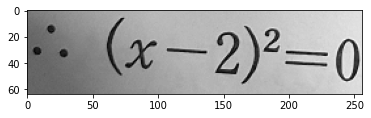

In [17]:
print(idx)
plt.imshow(train_dataset[idx]['image'][0], cmap='gray')
idx += 1

In [18]:
from networks.SATRN import DeepCNN300

In [19]:
use_cuda = True
device = torch.device('cuda' if torch.cuda.is_available() and use_cuda else 'cpu')
device

device(type='cuda')

In [20]:
import torch.nn as nn

In [21]:
class RotPrediction(nn.Module):
    def __init__(self, dropout_rate, rgb=1):
        super().__init__()
        
        output_channel = 300
        self.backbone = DeepCNN300(
            rgb,
            num_in_features=48,
            output_channel=output_channel,
            dropout_rate=dropout_rate,
        )
        
        self.middle = nn.Sequential(
            nn.Conv2d(output_channel, 16, 1),
            nn.Dropout(0.1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((4, 4)), # B, 16, 4, 4
            nn.Flatten(), # B, 16 * 4 * 4 = 256
        )
        self.rotation_head = nn.Linear(256, 4)
        self.flip_head = nn.Linear(256, 2)
    
    def forward(self, x):
        x = self.backbone(x)
        
        x = self.middle(x)
        rot = self.rotation_head(x)
        flip = self.flip_head(x)
        
        return rot, flip
        

In [22]:
rgb = 1

model = RotPrediction(
    dropout_rate=0.1,
    rgb=rgb,
) # 출력 대충 [B, output_channel, H//8, W//8]

model.to(device)
print()

In [23]:
epochs = 10

In [24]:
from torch.cuda.amp import (
    GradScaler, 
    autocast,
)

from tqdm.auto import tqdm

In [25]:
def run_epoch(
    data_loader,
    model,
    epoch_text,
    criterion,
    optimizer, 
    lr_scheduler,
    max_grad_norm,
    device,
#     options,
    use_amp=False,
    train=True,
):
    # Disables autograd during validation mode
    torch.set_grad_enabled(train)
    if train:
        model.train()
        scaler = GradScaler(enabled=use_amp)
    else:
        model.eval()

    losses = []
    total_inputs = 0
    correct_rotations = 0
    correct_flips = 0

    with tqdm(
        desc="{} ({})".format(epoch_text, "Train" if train else "Validation"),
        total=len(data_loader.dataset),
        dynamic_ncols=True,
        leave=False,
    ) as pbar:
        for d in data_loader:
            input = d["image"].to(device)

            # The last batch may not be a full batch
            curr_batch_size = len(input)
            exp_rotated = d["truth"]["rotated"].to(device)
            exp_flipped = d["truth"]["flipped"].to(device)
            
            with autocast(enabled=use_amp):
                pred_rot, pred_flip = model(input)

                loss_rot = criterion(pred_rot, exp_rotated)
                loss_flip = criterion(pred_flip, exp_flipped)
                
                loss = loss_rot + loss_flip

            if train:
                optimizer.zero_grad()
                
                scaler.scale(loss).backward()
                scaler.unscale_(optimizer)
                
                # Clip gradients, it returns the total norm of all parameters
                nn.utils.clip_grad_norm_(
                    model.parameters(), max_norm=max_grad_norm
                )


                # cycle
                scaler.step(optimizer)
                scale = scaler.get_scale()
                scaler.update()
                step_scheduler = scaler.get_scale() == scale

                if step_scheduler:
                    lr_scheduler.step()

            losses.append(loss.item() * len(input))
            total_inputs += len(input)

            prot = torch.argmax(pred_rot, dim=-1)
            pflip = torch.argmax(pred_flip, dim=-1)
            
            correct_rotations += (exp_rotated == prot).sum().item()
            correct_flips += (exp_flipped == pflip).sum().item()

            pbar.update(curr_batch_size)


    result = {
        "loss": np.sum(losses) / total_inputs,
        "correct_rotations": correct_rotations / total_inputs,
        "correct_flips": correct_flips / total_inputs,
    }

    return result


In [26]:
from adamp import AdamP

epochs = 10
lr = 5e-4
criterion = nn.CrossEntropyLoss()

optimizer = AdamP(model.parameters(), lr=lr)
lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, 
                        steps_per_epoch=len(train_data_loader), epochs=epochs,anneal_strategy='linear')

max_grad_norm = 1

In [27]:
import wandb

wandb.init(project='ocr',
        entity='rolypolyvg295',
        tags=['rot_flip', 'v2'], name='rotation flip',
)
wandb.watch(model)

wandb: Currently logged in as: rolypolyvg295 (use `wandb login --relogin` to force relogin)


In [28]:
for epoch in range(epochs):
    train_result = run_epoch(
        train_data_loader,
        model,
        'train',
        criterion,
        optimizer, 
        lr_scheduler,
        max_grad_norm,
        device,
        use_amp=True,
        train=True,
    )
    
    val_result = run_epoch(
        valid_data_loader,
        model,
        'valid',
        criterion,
        optimizer, 
        lr_scheduler,
        max_grad_norm,
        device,
        use_amp=True,
        train=False,
    )
    
    train_loss = train_result['loss']
    train_correct_rotations = train_result['correct_rotations']
    train_correct_flips = train_result['correct_flips']
    
    val_loss = val_result['loss']
    val_correct_rotations = val_result['correct_rotations']
    val_correct_flips = val_result['correct_flips']
    

    print(f'Epoch {epoch}')
    print(f'Train      Loss: {train_loss}')
    print(f'Train  Rot Accr: {train_correct_rotations}')
    print(f'Train Flip Accr: {train_correct_flips}')
    print(f'  Val      Loss: {val_loss}')
    print(f'  Val  Rot Accr: {val_correct_rotations}')
    print(f'  Val Flip Accr: {val_correct_flips}')
    print()
    
    logging_stuff = {
        'train_loss':train_loss,
        'train_correct_rotations':train_correct_rotations,
        'train_correct_flips':train_correct_flips,
        'val_loss':val_loss,
        'val_correct_rotations':val_correct_rotations,
        'val_correct_flips':val_correct_flips,
    }
    wandb.log(logging_stuff, step=epoch)
    torch.save(model.state_dict(), f'/opt/ml/input/data/rot_model/latest.pth')

train (Train):   0%|          | 0/800 [00:00<?, ?it/s]

valid (Validation):   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 0
Train      Loss: 1.9773438131809236
Train  Rot Accr: 0.39875
Train Flip Accr: 0.4825
  Val      Loss: 1.8354633748531342
  Val  Rot Accr: 0.4875
  Val Flip Accr: 0.5



train (Train):   0%|          | 0/800 [00:00<?, ?it/s]

valid (Validation):   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 1
Train      Loss: 1.6580866688489915
Train  Rot Accr: 0.53375
Train Flip Accr: 0.535
  Val      Loss: 1.698494267463684
  Val  Rot Accr: 0.4625
  Val Flip Accr: 0.5625



train (Train):   0%|          | 0/800 [00:00<?, ?it/s]

valid (Validation):   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 2
Train      Loss: 1.4473353433609009
Train  Rot Accr: 0.535
Train Flip Accr: 0.6325
  Val      Loss: 2.1830654382705688
  Val  Rot Accr: 0.325
  Val Flip Accr: 0.6125



train (Train):   0%|          | 0/800 [00:00<?, ?it/s]

valid (Validation):   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 3
Train      Loss: 1.3790548580884934
Train  Rot Accr: 0.5125
Train Flip Accr: 0.65625
  Val      Loss: 1.3901958167552948
  Val  Rot Accr: 0.525
  Val Flip Accr: 0.625



train (Train):   0%|          | 0/800 [00:00<?, ?it/s]

valid (Validation):   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 4
Train      Loss: 1.2428194326162338
Train  Rot Accr: 0.55125
Train Flip Accr: 0.75
  Val      Loss: 1.349914652109146
  Val  Rot Accr: 0.55
  Val Flip Accr: 0.7625



train (Train):   0%|          | 0/800 [00:00<?, ?it/s]

valid (Validation):   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 5
Train      Loss: 1.1669956213235855
Train  Rot Accr: 0.6025
Train Flip Accr: 0.765
  Val      Loss: 1.2871156275272368
  Val  Rot Accr: 0.6125
  Val Flip Accr: 0.8



train (Train):   0%|          | 0/800 [00:00<?, ?it/s]

valid (Validation):   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 6
Train      Loss: 1.090903437435627
Train  Rot Accr: 0.65375
Train Flip Accr: 0.79875
  Val      Loss: 1.3241722345352174
  Val  Rot Accr: 0.5875
  Val Flip Accr: 0.9



train (Train):   0%|          | 0/800 [00:00<?, ?it/s]

valid (Validation):   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 7
Train      Loss: 0.9865608312189579
Train  Rot Accr: 0.6875
Train Flip Accr: 0.83625
  Val      Loss: 1.342157816886902
  Val  Rot Accr: 0.5375
  Val Flip Accr: 0.8625



train (Train):   0%|          | 0/800 [00:00<?, ?it/s]

valid (Validation):   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 8
Train      Loss: 0.9375988978147507
Train  Rot Accr: 0.7275
Train Flip Accr: 0.855
  Val      Loss: 1.2850852966308595
  Val  Rot Accr: 0.5875
  Val Flip Accr: 0.7625



train (Train):   0%|          | 0/800 [00:00<?, ?it/s]

valid (Validation):   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 9
Train      Loss: 0.8457695011794567
Train  Rot Accr: 0.7775
Train Flip Accr: 0.89375
  Val      Loss: 1.401783972978592
  Val  Rot Accr: 0.5125
  Val Flip Accr: 0.8625



In [29]:
for i in range(len(train_data_loader.dataset)):
    train_data_loader.dataset[i]